# Temporal Aggregation

In this tutorial, we'll use wxee to aggregate time series image collections over time. Image collections can be aggregated to monthly, weekly, daily, and hourly frequencies, but the input data must have finer temporal resolution than the output (e.g. daily data can be aggregated to weekly, but not vice versa).

## Setup

In [1]:
import ee
import wxee

ee.Initialize()

## Create a Time Series

Time-based methods in wxee, like temporal aggregation and climatology, work with the `TimeSeries` subclass of `ee.ImageCollection`. To use them, we'll need to create a `TimeSeries`. There are two ways to do this.

### From an Image Collection
Create an `ee.ImageCollection` and use the `wx` accessor and the `to_time_series` method to convert the Image Collection to a `TimeSeries`. 

In [2]:
rtma = ee.ImageCollection("NOAA/NWS/RTMA")
ts = rtma.wx.to_time_series()

### From Scratch
As a shortcut, you can create a `TimeSeries` just like you would create an `ee.ImageCollection`. Just pass a collection ID or list of Images.

In [3]:
ts = wxee.TimeSeries("NOAA/NWS/RTMA")

## Aggregate Hourly to Daily

Now that we have out time series, let's get two days of wind velocity grids. The collection should contain 48 images--one per hour.

In [4]:
ts = ts.filterDate("2020-09-08", "2020-09-10").select("WIND")

This is a good time to introduce the `wxee.TimeSeries.describe()` method, which simply prints out some helpful information about our time series. As expected, we have 48 images and the mean interval between images is 1 hour.

In [5]:
ts.describe(unit="hour")

NOAA/NWS/RTMA
	Images: 48
	Start date: 2020-09-08 00:00:00 UTC
	End date: 2020-09-09 23:00:00 UTC
	Mean interval: 1.00 hours


Now we'll aggregate hourly data to daily data. By default, `aggregate_time` uses `ee.Reducer.mean()` to aggregate data, so the output will represent average daily wind speeds. The 48 hourly input images have been aggregated into 2 daily images.

In [6]:
daily = ts.aggregate_time(frequency="day")
daily.describe()

NOAA/NWS/RTMA
	Images: 2
	Start date: 2020-09-08 00:00:00 UTC
	End date: 2020-09-09 00:00:00 UTC
	Mean interval: 1.00 days


Now we can download and visualize the daily data.

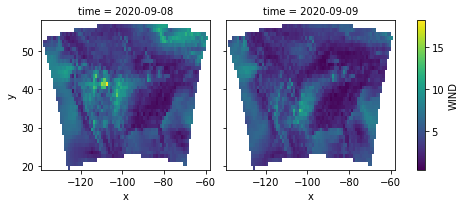

In [7]:
x = daily.wx.to_xarray()
x.WIND.plot(col="time")

## Aggregate Daily to Monthly

gridMET contains daily temperature data. We'll load a time series with one year of data from 2020, giving us 366 images (2020 was a leap year).

In [8]:
gridmet = wxee.TimeSeries("IDAHO_EPSCOR/GRIDMET").select("tmmx")
gridmet = gridmet.filterDate("2020-01", "2021-01")
gridmet.describe()

IDAHO_EPSCOR/GRIDMET
	Images: 366
	Start date: 2020-01-01 06:00:00 UTC
	End date: 2020-12-31 06:00:00 UTC
	Mean interval: 1.00 days


Now, we'll calculate the monthly maximum temperatures, download them an xarray dataset, and plot them by month.

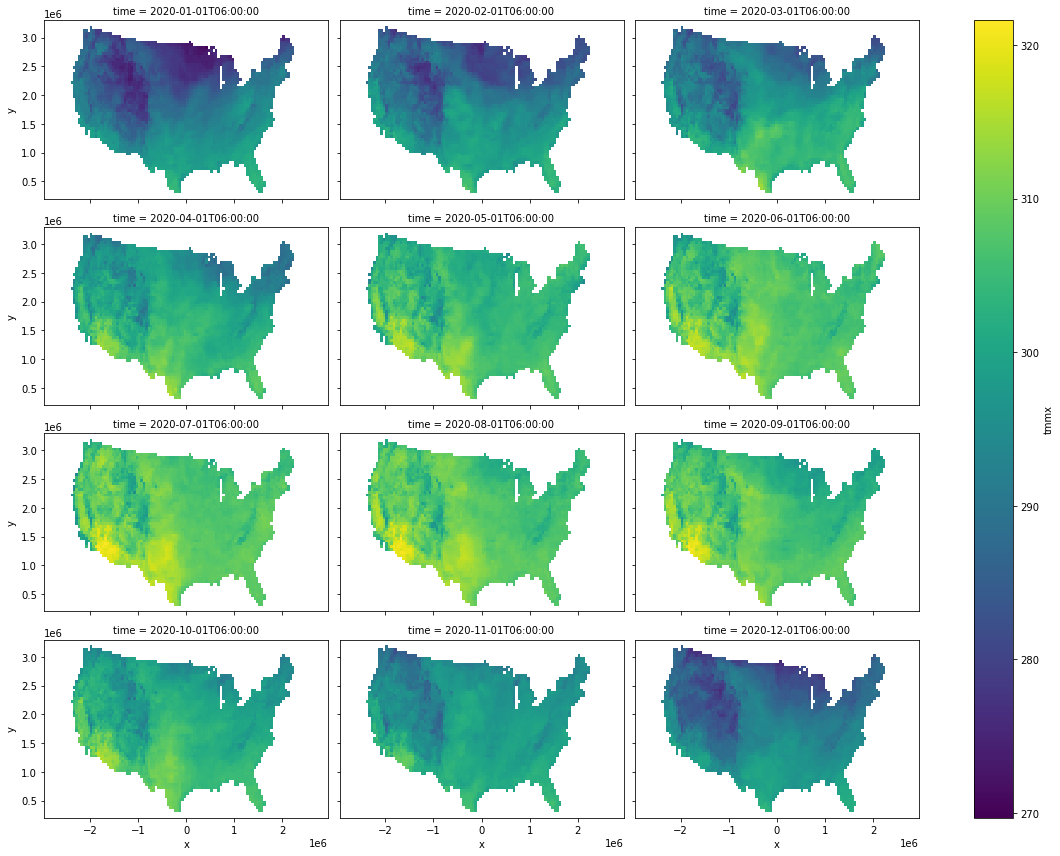

In [9]:
monthly = gridmet.aggregate_time(frequency="month", reducer=ee.Reducer.max())

x = monthly.wx.to_xarray(scale=50_000, crs="EPSG:5070")
x.tmmx.plot(col="time", col_wrap=3, figsize=(16, 12))

## Warning

wxee's temporal resampling methods can only be used to aggregate fine time steps into coarse time steps (e.g. hours to days, days to months). Resampling a temporally coarse dataset into a finer time unit may lead to invalid results. Below, you can see that attempting to resample daily data into hourly caused one of the images to be lost.

In [10]:
gridmet = wxee.TimeSeries("IDAHO_EPSCOR/GRIDMET").select("tmmx")
gridmet = gridmet.filterDate("2020-01", "2020-02")

gridmet.size().getInfo()

31

In [11]:
gridmet.aggregate_time("hour").size().getInfo()

30